In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import connections
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
from elasticsearch_dsl.query import MultiMatch, Match
from collections import Counter, deque
from itertools import count
from uuid import uuid4

import distill
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import itertools
import networkx as nx
import hashlib, base64
import plotly.graph_objects as go

# Define Search

create new connection to test instance, given an alias 'flagonTest' for later reference
note: connections are easy enough such that examples are enough, no need for further abstraction

In [2]:
flagonClient = connections.create_connection('flagonTest', hosts=['localhost:9200'], timeout=60)

#TODO describeabs connections

#hello world test
print(flagonClient)

<Elasticsearch([{'host': 'localhost', 'port': 9200}])>


In [3]:
AleS = Search(using='flagonTest', index="userale")

# Define Queries

## Simple Queries

In [4]:
qLogType = Q("match", logType="raw") | Q("match", logType="custom")
print(qLogType)

Bool(should=[Match(logType='raw'), Match(logType='custom')])


In [5]:
qUserId = Q("match", userId="superset-user")
print(qUserId)

Match(userId='superset-user')


In [6]:
qExcludeSession = Q("match", sessionID="") & Q("match", sessionID="")
print(qExcludeSession)

Bool(must=[Match(sessionID=''), Match(sessionID='')])


## Not-As-Simple Queries

In [7]:
qUrl = Q({"wildcard": {
    "pageUrl": {
        "value": "*/superset/dashboard*"
    }
}})
print(qUrl)

Wildcard(pageUrl={'value': '*/superset/dashboard*'})


## Define Filters

In [8]:
filterEvents = Q('bool', filter=[~Q('terms', type=['mouseover','wheel','keydown','scroll'])])
print(filterEvents)

Bool(filter=[Bool(must_not=[Terms(type=['mouseover', 'wheel', 'keydown', 'scroll'])])])


# Chained Searches

In [9]:
elk_search = AleS \
    .query(qUrl) \
    .query(qLogType) \
    .query(qUserId) \
    .query(filterEvents) \
    .extra(track_total_hits=True) #breaks return limit of 10000 hits

NOTE: `.execute()` will only retreive the first 10 hits with additional terms embedded in queries. Use `.scan()` instead if you want to retreive all the hits. We use `.execute()` below for brevity.

In [10]:
ale_dict = {}
elk_response = elk_search.scan()
for hit in elk_response:
    logEntry = (hit.to_dict())
    logEntry['uid'] = distill.getUUID(logEntry)
    logEntry['clientTime'] = distill.epoch_to_datetime(logEntry['clientTime'])
    ctr = len(ale_dict)
    ctr += 1
    ale_dict[ctr] = logEntry

print(len(ale_dict))

998


# Data Forensics

In [11]:
sorted_data = dict(sorted(ale_dict.items(), key = lambda kv: kv[1]['clientTime']))
len(sorted_data)

998

In [12]:
sessions = distill.find_meta_values('sessionID', sorted_data)
sessions

['session_1640200820004',
 'session_1640118177195',
 'session_1641844965430',
 'session_1641584276813',
 'session_1641502434428',
 'session_1640029398947']

In [13]:
users = distill.find_meta_values('userId', sorted_data)
users 

['superset-user']

In [14]:
values = ['path']
sorted_data_paths = {k:v for k, v in sorted_data.items() if any(item in values for item in v.keys())}
len(sorted_data_paths)

995

In [15]:
values = ['click']
sorted_data_paths_clicks = {k:v for k, v in sorted_data_paths.items() if any(item in values for item in v.values())}
len(sorted_data_paths_clicks)

186

In [16]:
ele = ['div.superset-legacy-chart-world-map']
sorted_data_pathele = {k:v for k, v in sorted_data_paths.items() if any(item in ele for item in v['path'])}
sorted_data_pathele.keys()

dict_keys([271, 272, 273, 187, 189, 270, 190, 191, 186, 268, 188, 259, 269, 260, 228, 277, 280, 199, 282, 256, 274, 276, 194, 196, 229, 231, 201, 283, 284, 204, 286, 233, 197, 262, 202, 203, 285, 287, 288, 289, 290, 278, 261, 281, 232, 234, 263, 230, 243, 218, 219, 245, 244, 246, 220, 221, 247, 222, 223, 248, 210, 212, 295, 296, 205, 291, 292, 208, 209, 211, 214, 237, 249, 224, 236, 240, 241, 242, 235, 293, 206, 294, 213, 215, 217, 207, 216, 238, 239, 195, 250, 264, 869, 546, 836, 543, 544, 545, 547, 548, 925, 920, 921, 922, 923, 558, 554, 928, 929, 930, 926, 931, 549, 550, 927, 551, 552, 553, 555, 556, 557, 559, 560, 561, 562, 563, 564, 565, 946, 576, 875, 649, 647, 648, 591, 593, 899])

# Segmentation

In [17]:
mapSegments = distill.generate_segments(sorted_data_paths,'path',['div.superset-legacy-chart-world-map','window'],0,30)
for counter, d in enumerate(mapSegments.values(), start=1):
    d.segment_name = str("map_" + str(counter))
    print(d.segment_name, d.start_end_val, d.num_logs)

map_1 (1640201161299, 1640201191299) 95
map_2 (1641849246535, 1641849276535) 70
map_3 (1641849283637, 1641849313637) 47
map_4 (1641849368424, 1641849398424) 22


In [18]:
mapSegments_list = []
mapSegment_times = []
for d in mapSegments.values():
    if d.num_logs > 50:
        mapSegments_list.append(d.segment_name)
        mapSegment_times.append(d.start_end_val)
        print(d.segment_name, d.start_end_val, d.num_logs)

map_1 (1640201161299, 1640201191299) 95
map_2 (1641849246535, 1641849276535) 70


In [19]:
filterDataBy = ['click']
sorted_data_paths_clicks = {k:v for k, v in sorted_data_paths.items() if any(item in values for item in v.values())}
len(sorted_data_paths_clicks)

186

In [21]:
mapSegments_data = distill.write_segment(sorted_data_paths_clicks, mapSegments_list, mapSegment_times)
list(mapSegments_data.keys())

['map_1', 'map_2']

# Exploratory Visualization

# Graphs and Stats

In [22]:
edges_map_1 = distill.pairwiseSeq(['|'.join(log['path']) for log in mapSegments_data['map_1'].values()])
edges_map_2 = distill.pairwiseSeq(['|'.join(log['path']) for log in mapSegments_data['map_2'].values()])

In [23]:
nodes_map_1 = set(['|'.join(log['path']) for log in mapSegments_data['map_1'].values()])
nodes_map_2 = set(['|'.join(log['path']) for log in mapSegments_data['map_2'].values()])

In [24]:
G_map1 = distill.createDiGraph(nodes_map_1, edges_map_1, drop_recursions = False)
G_map2 = distill.createDiGraph(nodes_map_2, edges_map_2, drop_recursions = False)

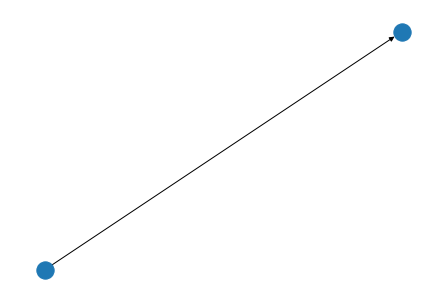

In [25]:
nx.draw(G_map1, with_labels=False)

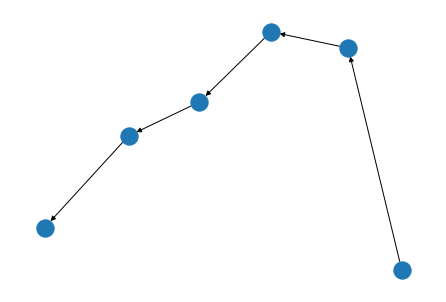

In [26]:
nx.draw(G_map2, with_labels=False)

In [27]:
nx.average_node_connectivity(G_map2)

0.5

In [ ]:
#clickRate

In [ ]:
edge_list_temp = []
for row in edges_segmentN:
    if row[0] != row[1]: 
        edge_list_temp.append(row)
edge_list = edge_list_temp

edge_list_counter = Counter(edge_list)

source_list = [i[0] for i in edge_list_counter.keys()]
target_list = [i[1] for i in edge_list_counter.keys()]
value_list = [i for i in edge_list_counter.values()]

nodes = []
for row in edge_list:
    for col in row:
        if col not in nodes:
            nodes.append(col)           
            
sources = []
for i in source_list:
       sources.append(nodes.index(i))
targets = []
for i in target_list:
        targets.append(nodes.index(i))
values = value_list

fig = go.Figure(data=[go.Sankey(
    node = dict(
      label = [nodes[item].split("|")[0] for item in range(len(nodes))],
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values
  ))])

fig.show()

# WIP

In [ ]:
x = [hashlib.md5('_'.join(log['path']).encode('utf-8')).digest() for log in finalSegments['...'].values()]
y = [hashlib.md5('_'.join(log['path']).encode('utf-8')).digest() for log in finalSegments['...'].values()]
set(x) & set (y)

In [ ]:
x = ['_'.join(log['path']) for log in finalSegments['...'].values()]
y = ['_'.join(log['path']) for log in finalSegments['...'].values()]
set(x) & set(y)

In [ ]:
nx.graph_edit_distance(G_segmentN, G_segmentN)

In [ ]:
for v in nx.optimize_graph_edit_distance(G_segmentN, G_segmentN):
    minv = v
minv